# Equivariance

A feature $f$ is equivariant wrt a transformation $t$ if there exists $t'$ such that $f(t(x)) = t'(f(x))$, ie, transforming with $t$ in the domain of $x$ is the same as transforming with $t'$ in the domaing of $f(x)$. 

This is important when $x$ is an image and usual examples for $t$ are translation, rotation or scaling of the image.

In the simplest case $t=t'$, the same transformation is applied to the input and the feature, but that does not need be the case.

In [1]:
# libraries and configs
%load_ext autoreload
%autoreload 2
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
from skimage.filters import gabor_kernel,gabor
import scipy.signal as signal
import skimage.transform as transform
from skimage import exposure

In [15]:
# visualize a filter's output after rotation of the image and the filter itself
def visualize_filter(image,base_filter,image_rotations,filter_rotations=np.array([0])):
    k=filter_rotations.shape[0]
    n=image_rotations.shape[0]
    for i in range(k):
        fig,axes=plt.subplots(2,n+2,figsize=(40,10),dpi=100)
        filter_rotation=filter_rotations[i]
        f = transform.rotate(base_filter,filter_rotation)
        axes[0,0].imshow(f)
        axes[1,0].imshow(base_filter)
        axes[0,1].imshow(image)
        axes[1,1].imshow(image)
        for j in range(n):
            image_rotation=image_rotations[j]
            rotated_image=transform.rotate(image,image_rotation,resize=False)
            convolved=signal.convolve2d(rotated_image,f,mode="same")
            convolved=exposure.equalize_hist(convolved)
            axes[0,j+2].imshow(convolved)
            axes[0,j+2].set_title("rotated by %d degrees then convolved" % image_rotation)
            
            convolved_rotated=signal.convolve2d(image,base_filter,mode="same")
            convolved_rotated=transform.rotate(convolved_rotated,image_rotation)
            convolved_rotated=exposure.equalize_hist(convolved_rotated)
            axes[1,j+2].imshow(convolved_rotated)
            axes[1,j+2].set_title("convolved then rotated by %d degrees" % image_rotation)
            
        plt.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.title("Rotate and then filter (row 1) vs Filter and then rotate (row 2), for various angles")
        plt.show()

(512, 512, 4)
(512, 512) float64 0.0 1.0


/home/facuq/dev/exp/rotation/.env/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


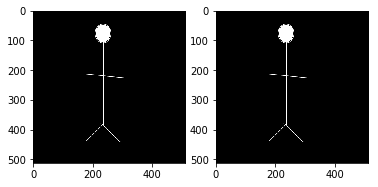

In [27]:


image=io.imread("person.png")
print(image.shape)
image=transform.resize(image,(512,512))
f,(a1,a2)=plt.subplots(1,2)
a1.imshow(image)

if len(image.shape)>2 and image.shape[2]>1:
    #image=np.mean(image,axis=2)
    image=image[:,:,1]
a2.imshow(image)
print(image.shape,image.dtype,image.min(),image.max())
plt.show()

# Equivariance to rotation $t(x)=r(x)$ with isotropic filters

For convolution, if the filter $F$ used in $f$ is isotropic, then $f(r(x))=r(f(x))$, ie, we have the case $t=t'=r$


Generating rotations at angles [  0.  45.  90. 135. 180. 225. 270. 315.]


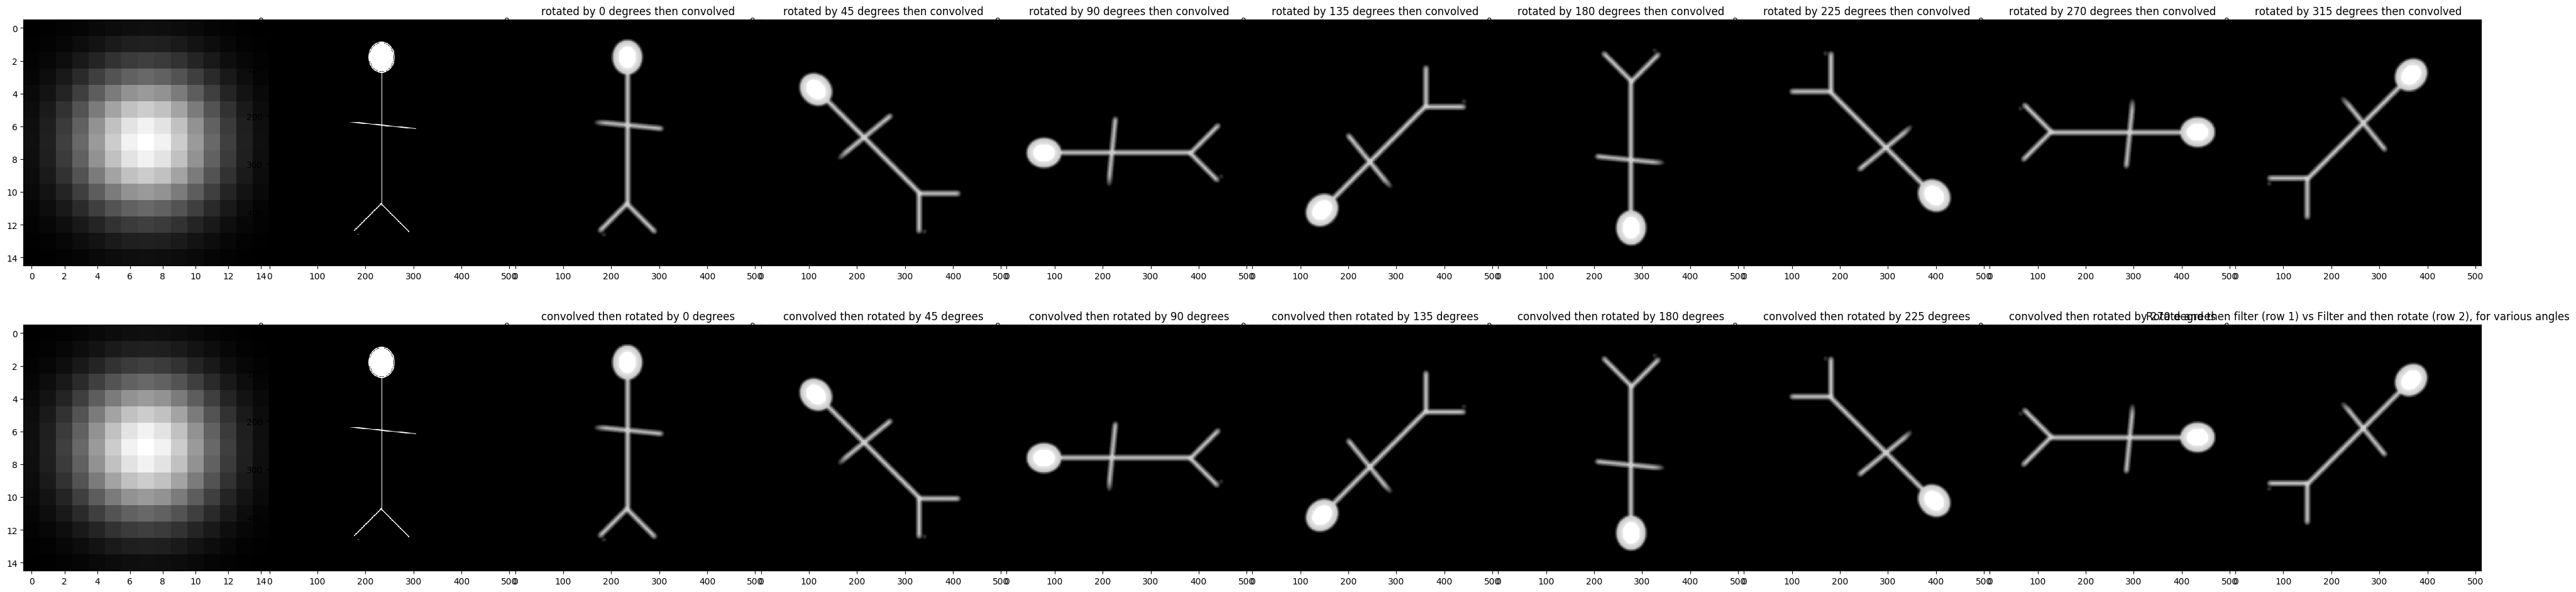

In [28]:
def gkern(width=5, sigma=1.):
    """
    creates isotropic gaussian kernel with side length l and a sigma of sig
    """

    ax = np.arange(-width // 2 + 1., width // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))

    return kernel / np.sum(kernel)

n=8
image_rotations=np.linspace(0,360,num=n,endpoint=False)
print("Generating rotations at angles %s" % str(image_rotations))

f = gkern(width=15,sigma=3)
filter_rotations=np.array([0])

visualize_filter(image,f,image_rotations,filter_rotations)

# Equivariance with anisotropic filters

If the filter is not isotropic, this does not mean the feature is not equivariant, but $t \neq t'$, so if the function $t'$ exists then it is more complicated:

Generating rotations at angles [ 0 45 90]


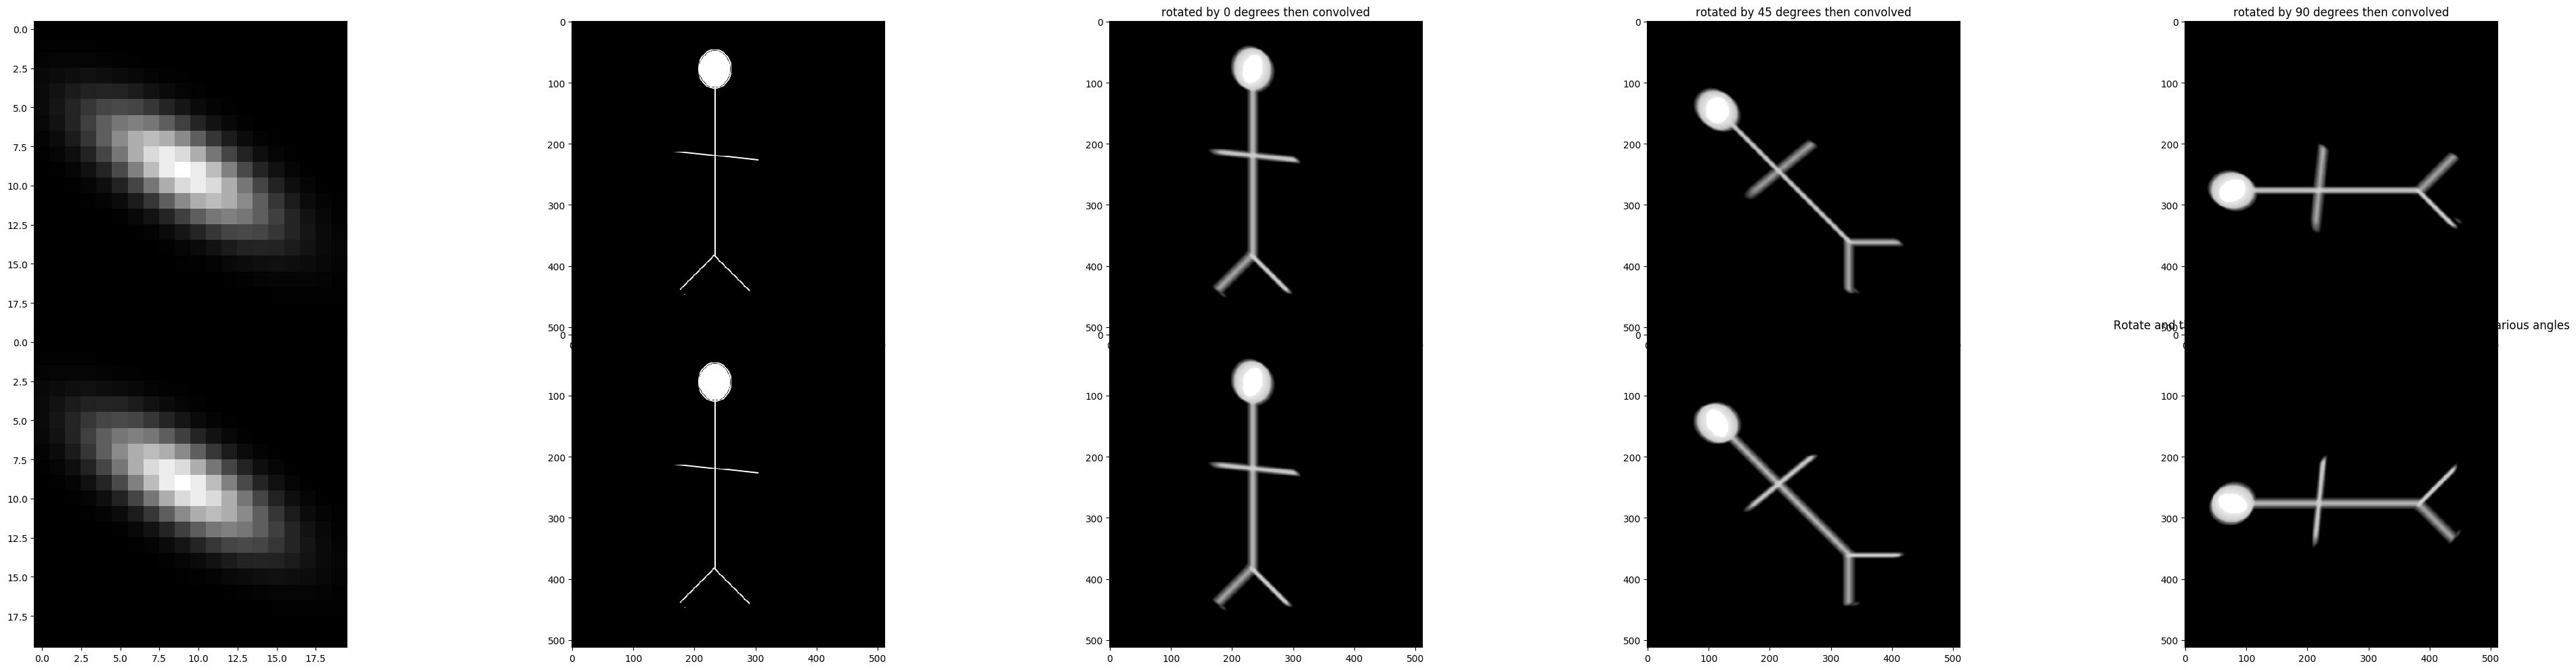

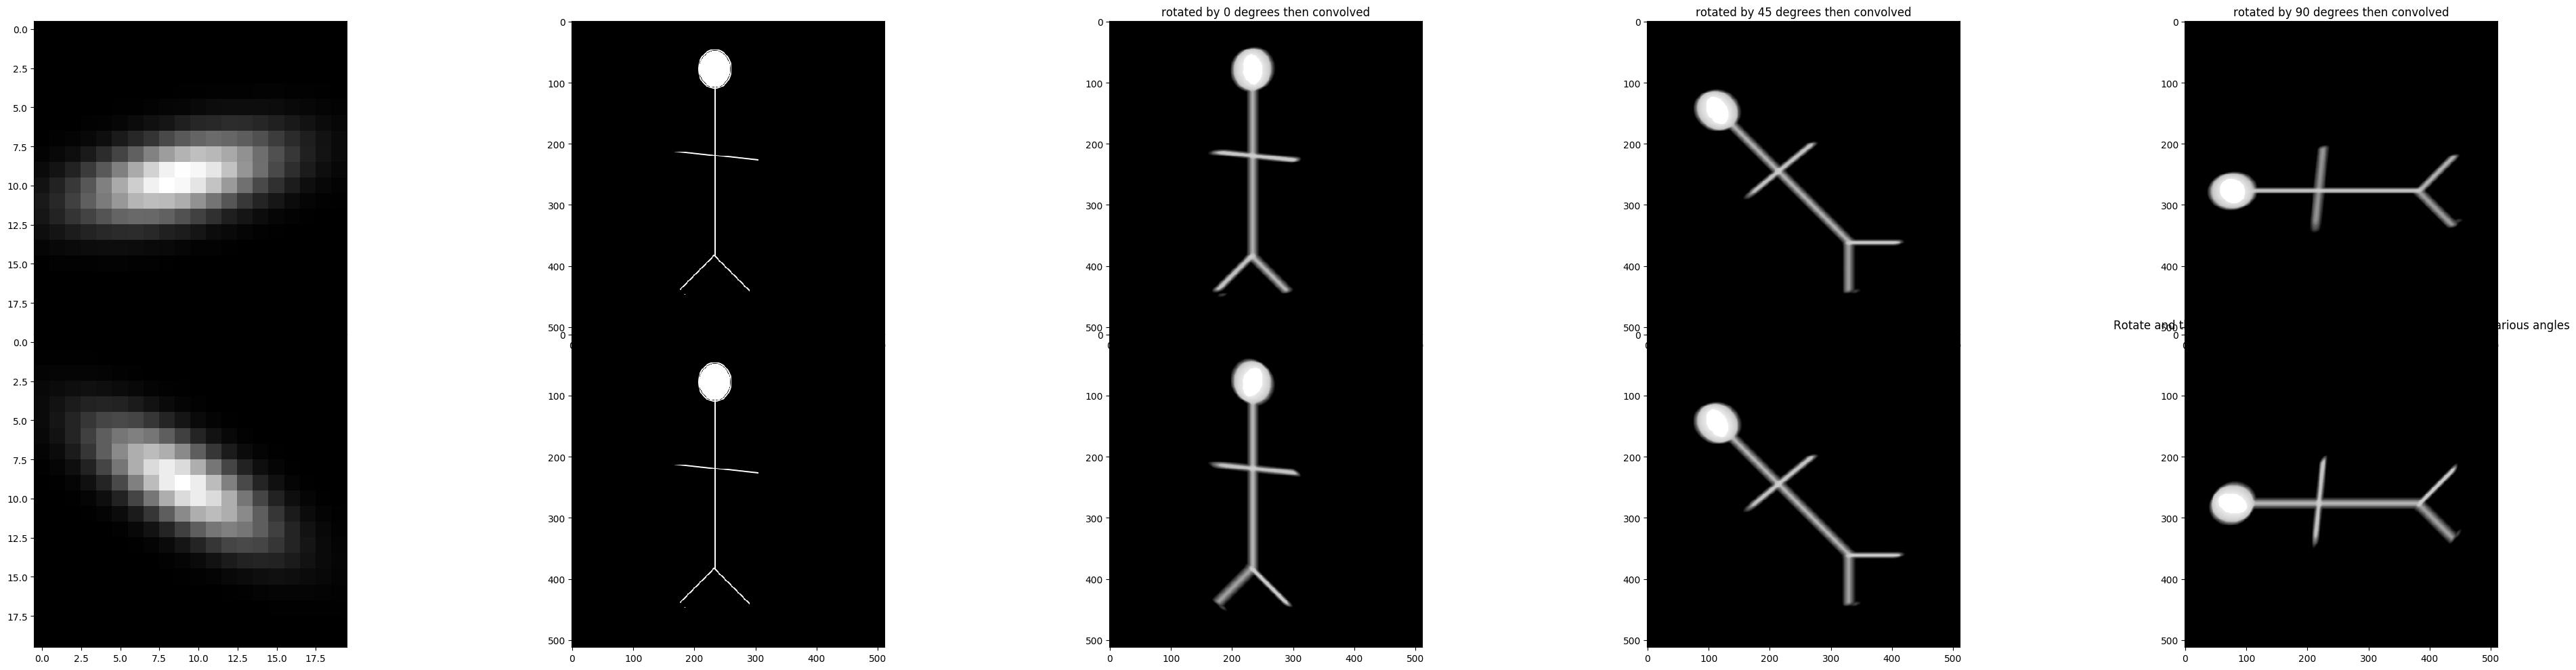

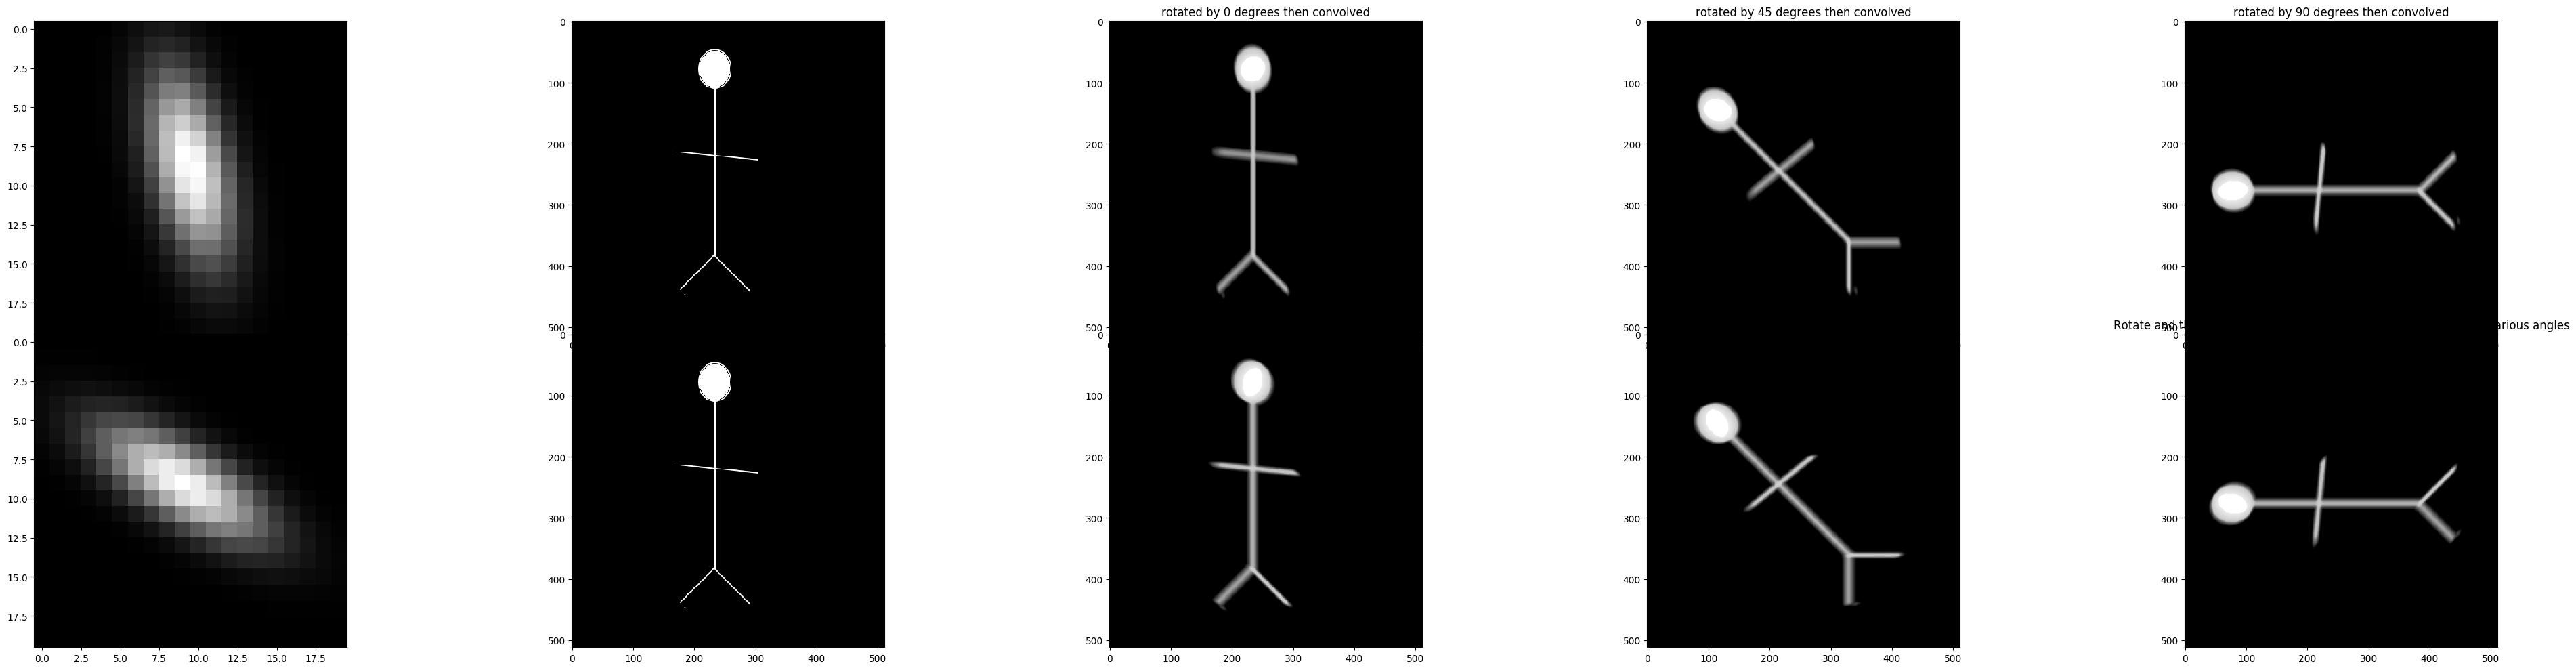

In [29]:
def gkern(cov,width=5):
    """
    creates gaussian kernel with side length l and a sigma of sig
    """

    icov=np.linalg.inv(cov)
    ax = np.arange(-width // 2 + 1., width // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    n,m=xx.shape
#     m=np.zeros( (2,n,m))
#     print(xx.shape,yy.shape,cov.shape)
#     m[0,:,:]=xx
#     m[1,:,:]=yy

    kernel=np.zeros_like(xx)
    for i in range(n):
        for j in range(m):
            c=np.array([xx[i,j],yy[i,j]])
            kernel[i,j] = np.exp(-( c.dot(icov).dot(c.T)))

    return kernel / np.sum(kernel)

n=8
image_rotations=np.linspace(0,360,num=n,endpoint=False)
image_rotations=np.array([0,45,90])
n=image_rotations.shape[0]
print("Generating rotations at angles %s" % str(image_rotations))


cov=np.array([[6,1],
              [5,3]])*3
f = gkern(cov,width=20)

filter_rotations=np.array([0,45,-45])

visualize_filter(image,f,image_rotations,filter_rotations)

# Equivariance with gabor filters


Generating rotations at angles [  0.  45.  90. 135. 180. 225. 270. 315.]
And filters rotated at angles [  0.  45.  90. 135. 180. 225. 270. 315.]


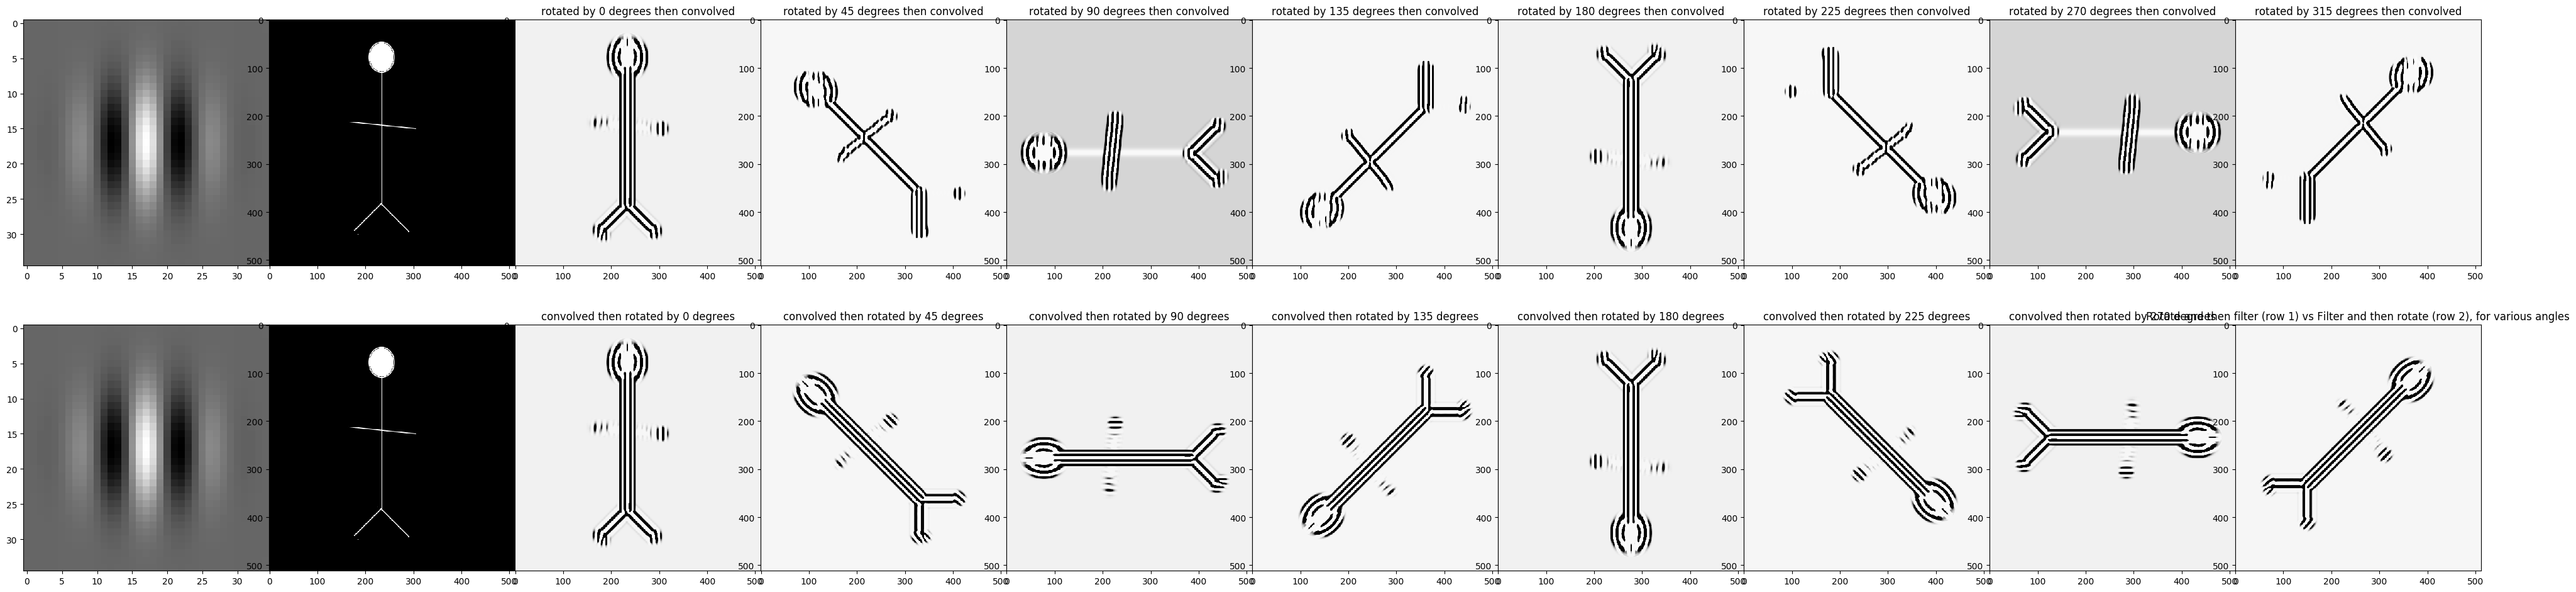

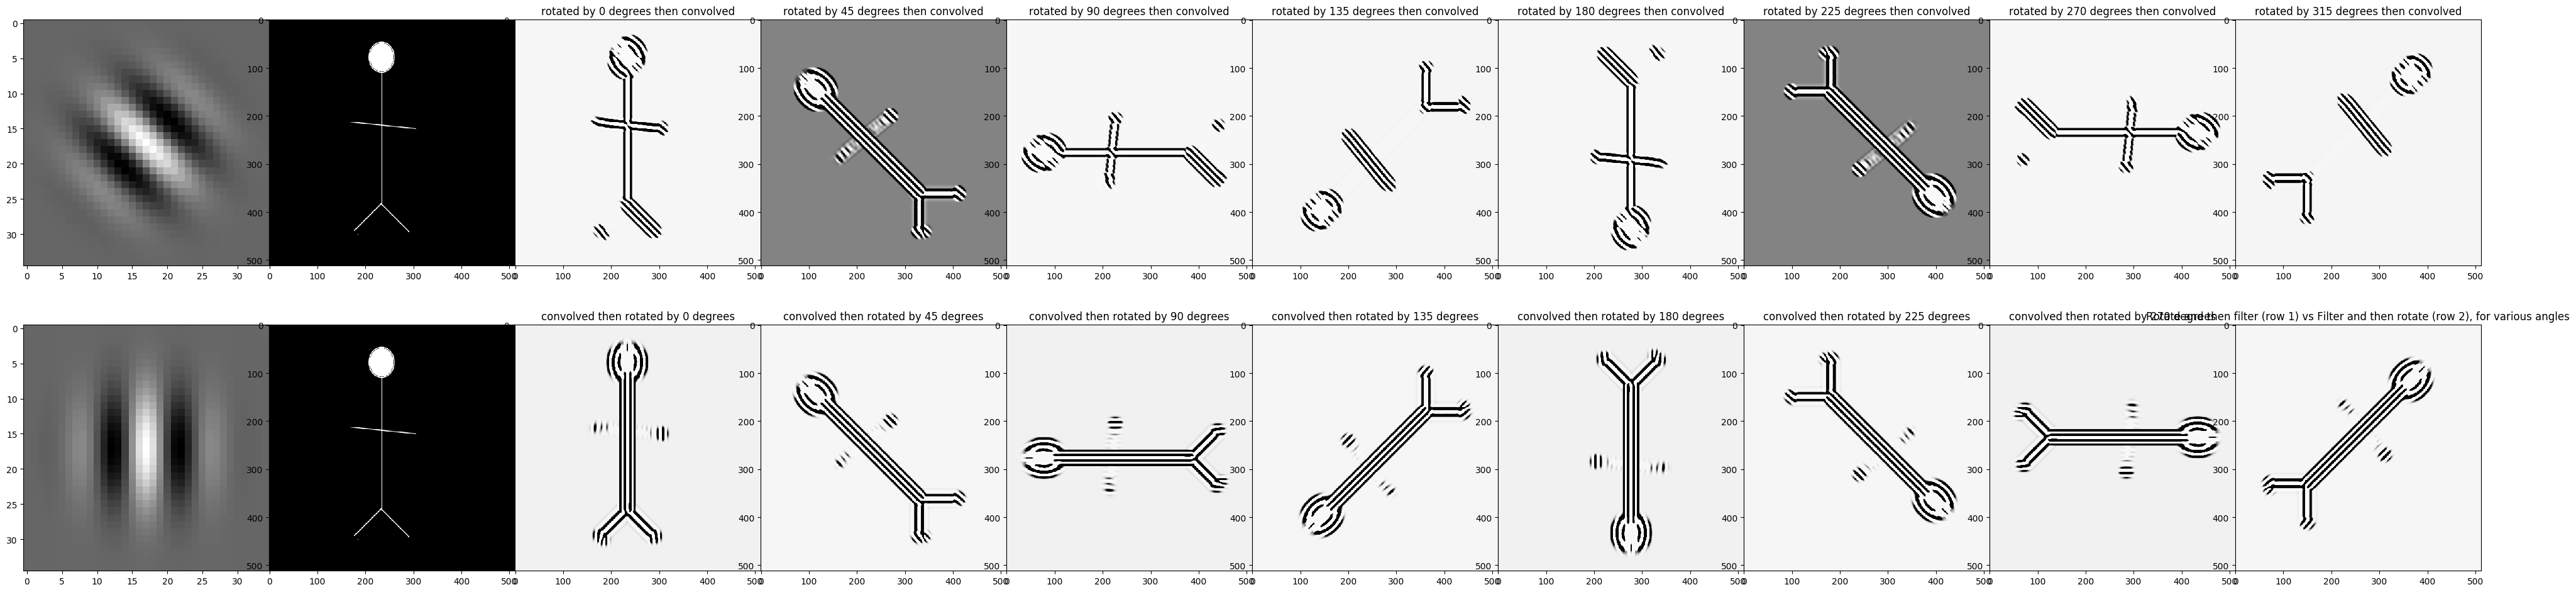

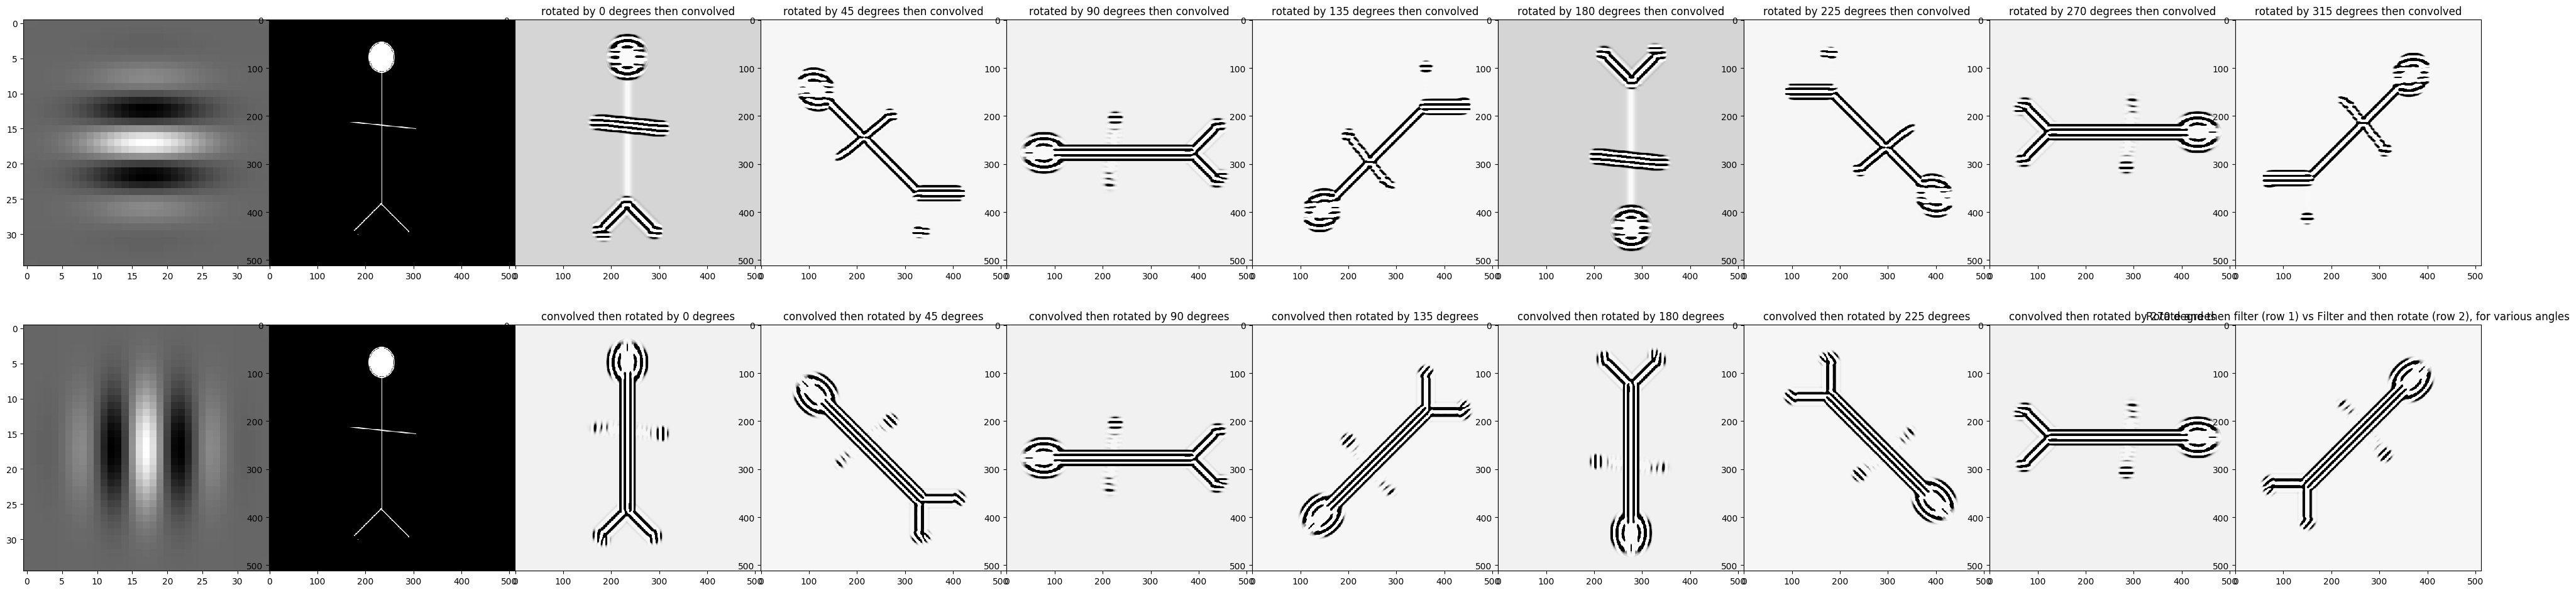

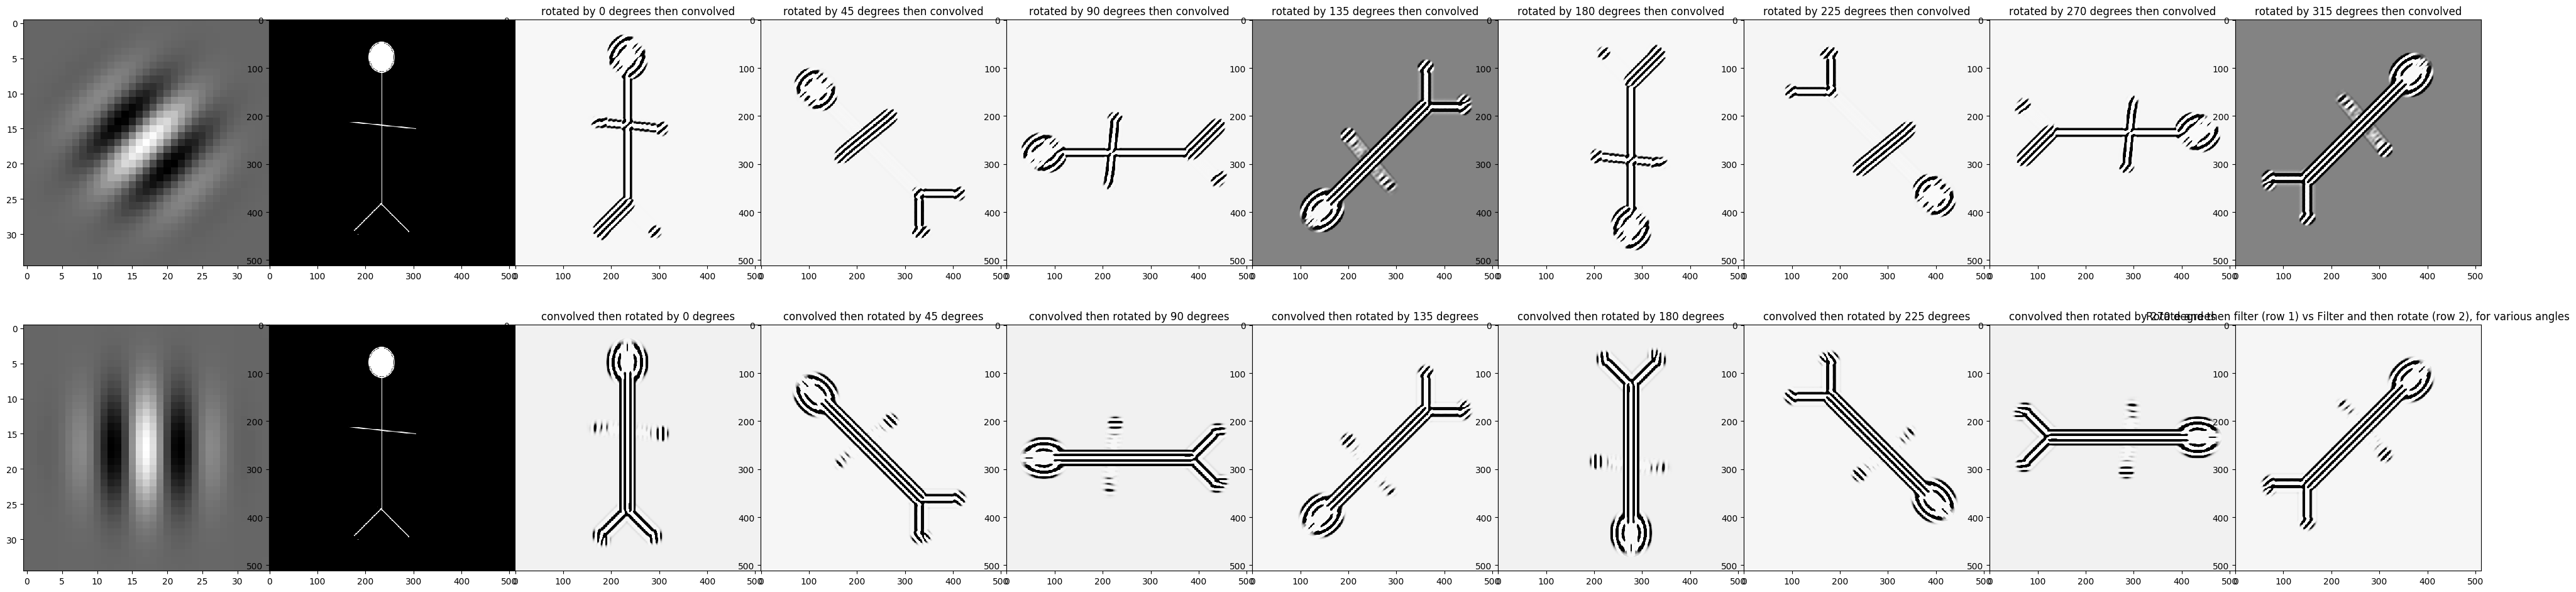

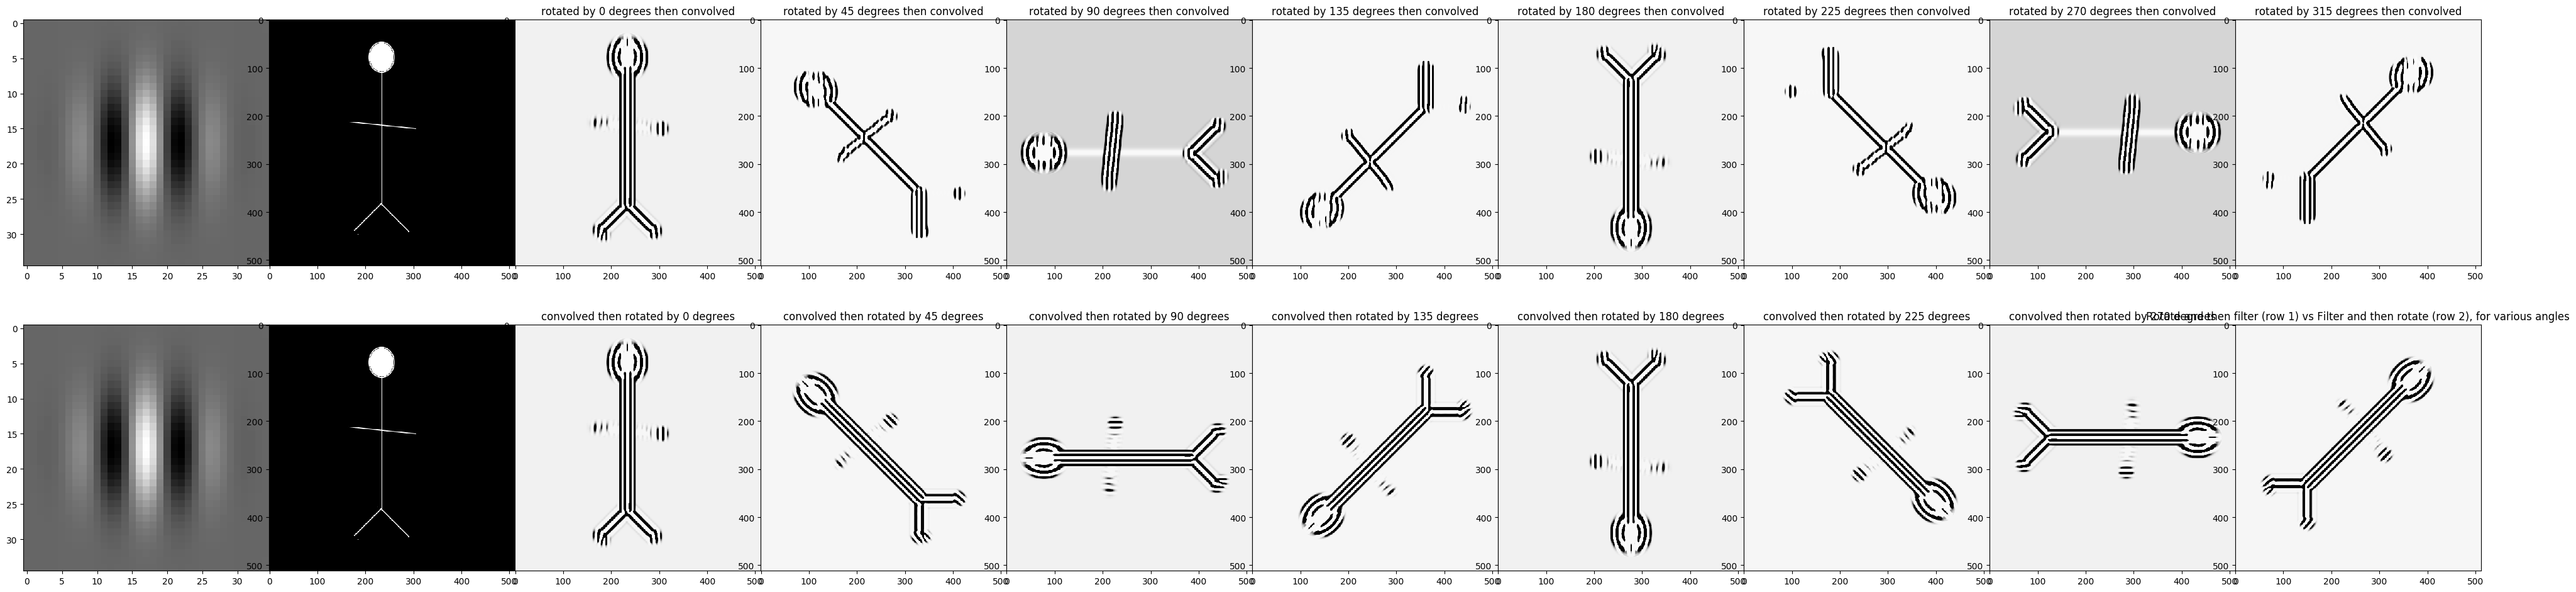

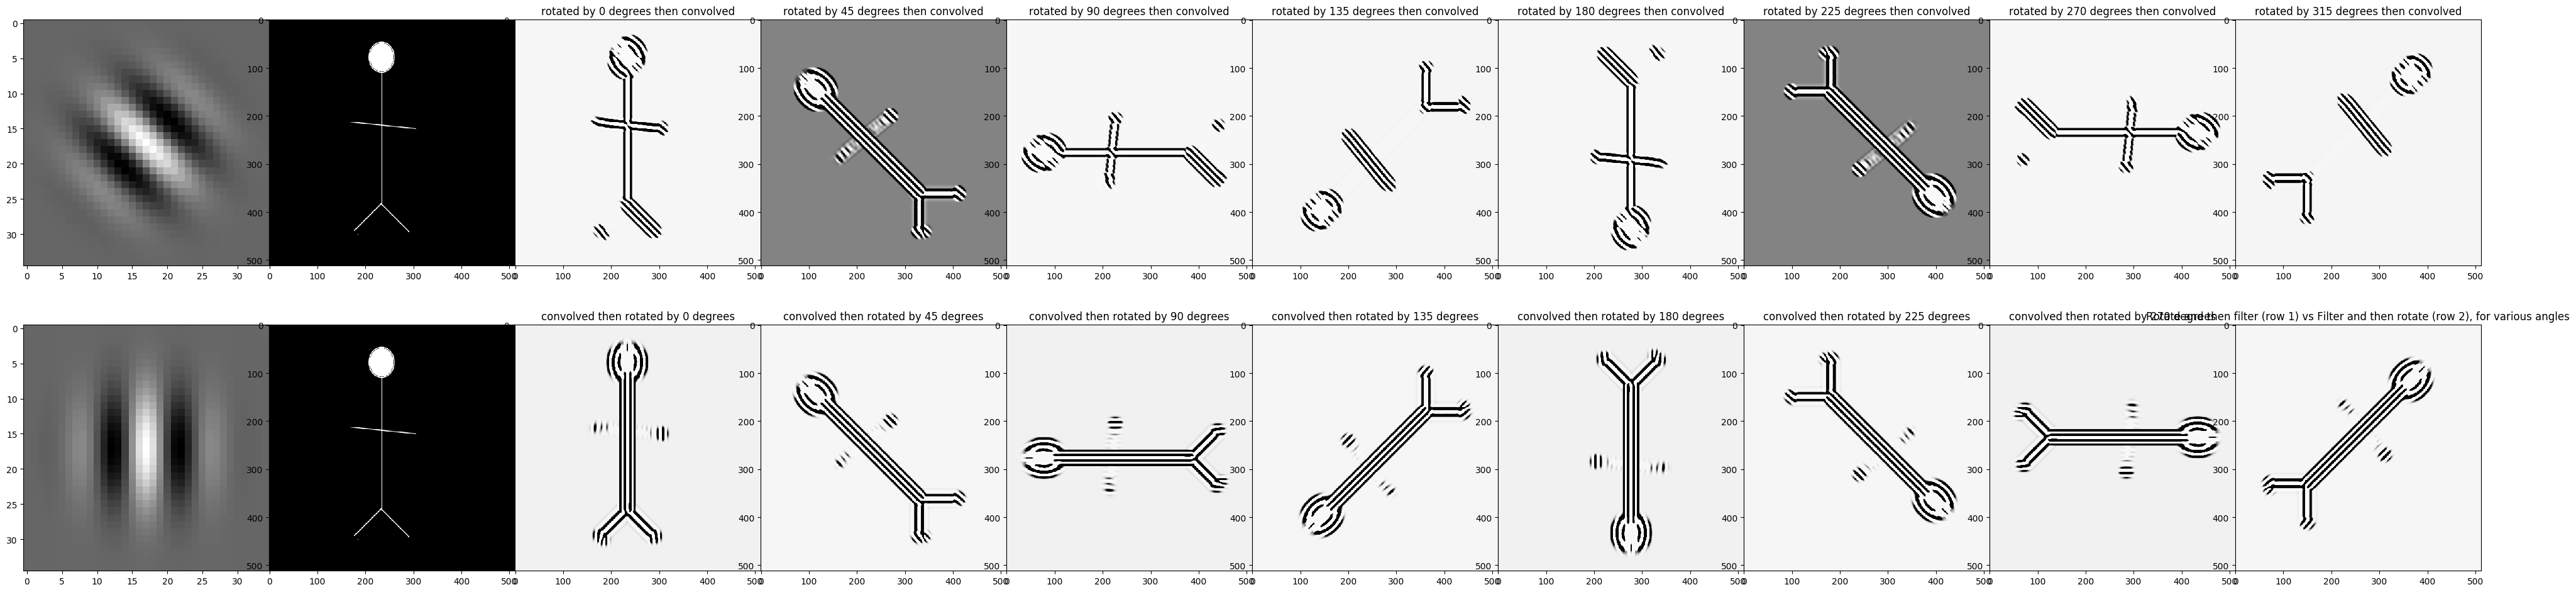

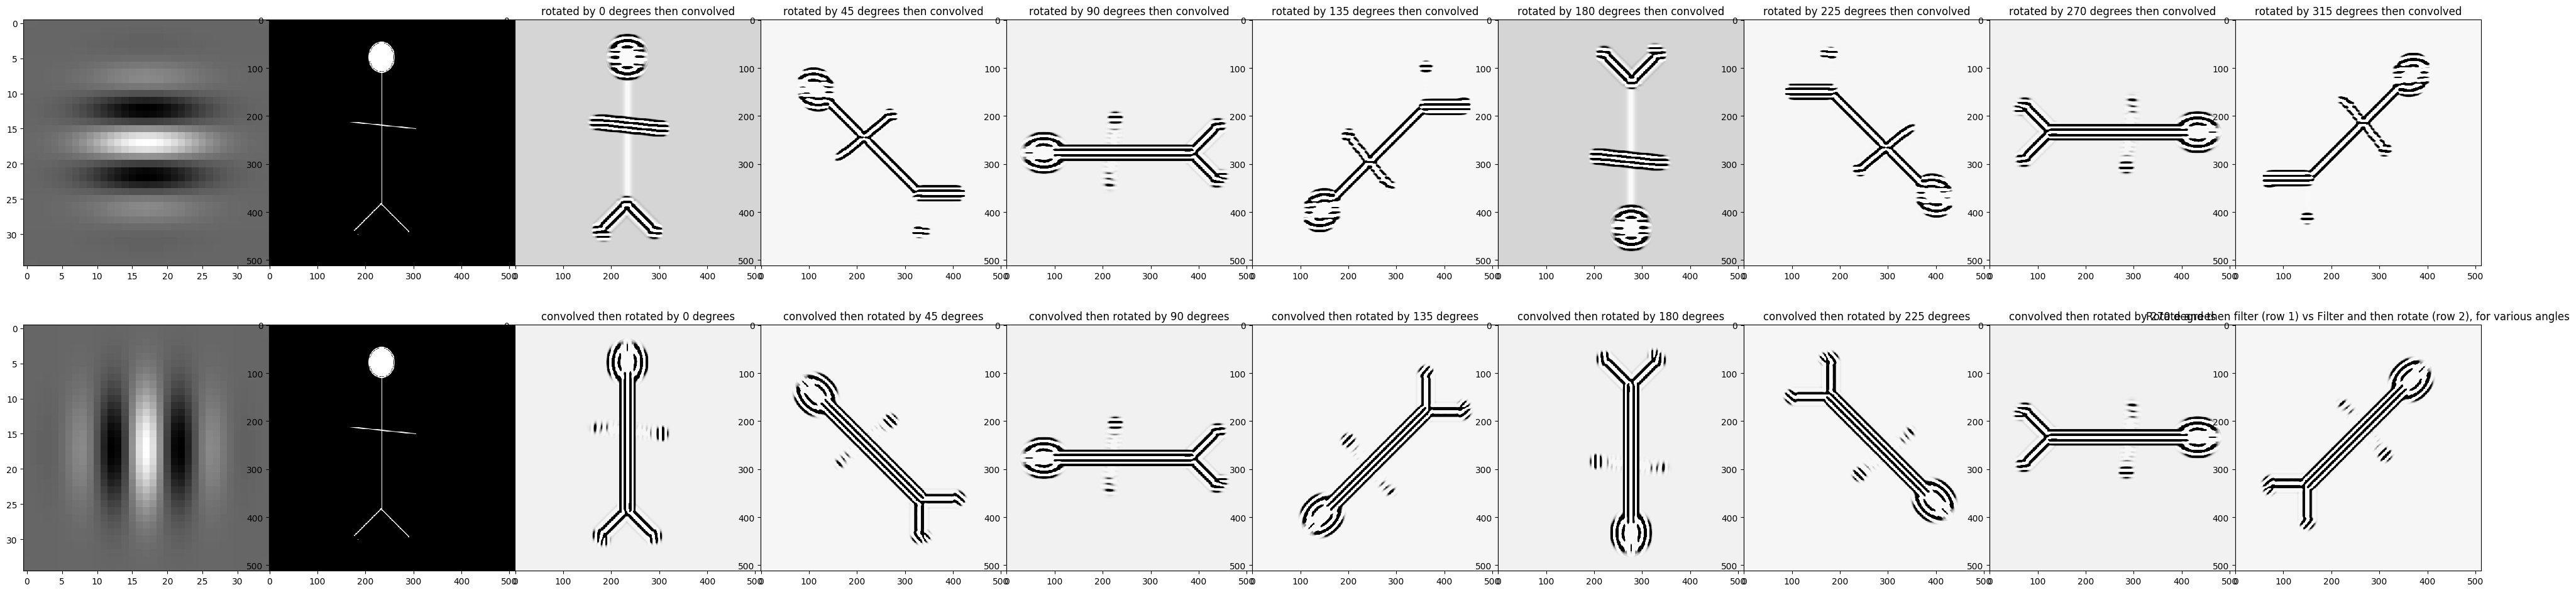

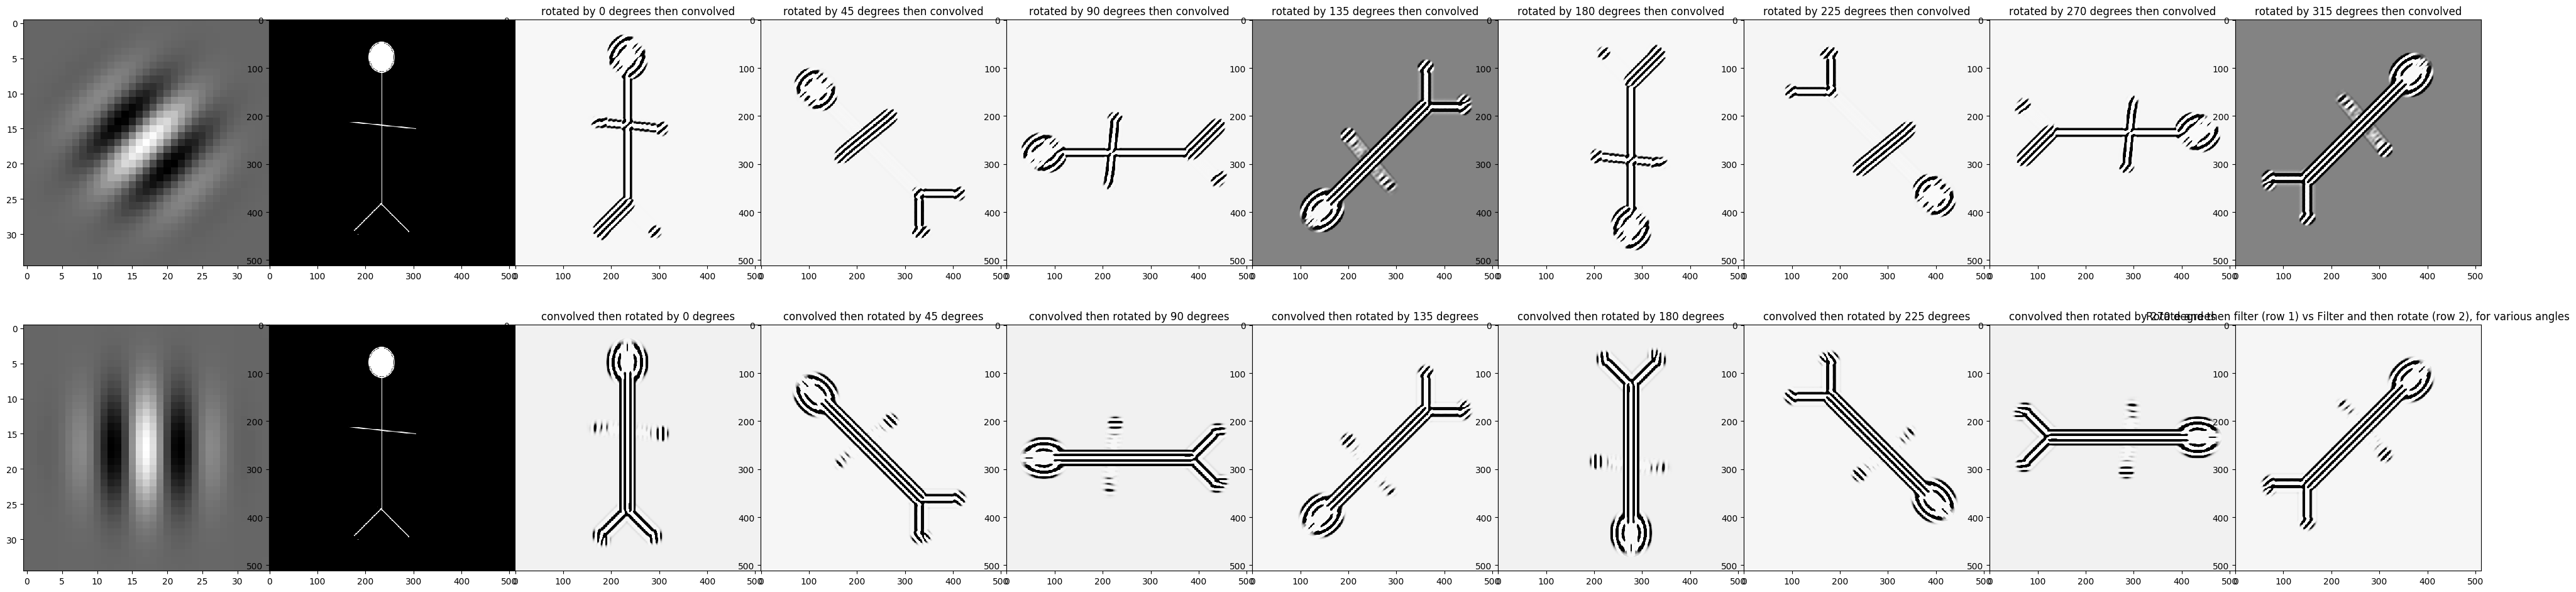

In [30]:
n=8
image_rotations=np.linspace(0,360,num=n,endpoint=False)
#image_rotations=np.array([45,90])
n=image_rotations.shape[0]
print("Generating rotations at angles %s" % str(image_rotations))
k=8
filter_rotations=np.linspace(0,360,num=k,endpoint=False)
print("And filters rotated at angles %s" % str(filter_rotations))

frequency=0.1
base_filter=gabor_kernel(frequency,theta=0).real
visualize_filter(image,base_filter,image_rotations,filter_rotations)
